# Image segmentation model using pytorch

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# ResNet Encoder
class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

# ASPP Module
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv_1x1_1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(out_channels)

        self.conv_3x3_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(out_channels)

        self.conv_3x3_2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(out_channels)

        self.conv_3x3_3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(out_channels)

        self.conv_1x1_2 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(out_channels)

        self.conv_1x1_3 = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        feature_map_h = x.size()[2]
        feature_map_w = x.size()[3]

        out_1x1_1 = self.relu(self.bn_conv_1x1_1(self.conv_1x1_1(x)))

        out_3x3_1 = self.relu(self.bn_conv_3x3_1(self.conv_3x3_1(x)))

        out_3x3_2 = self.relu(self.bn_conv_3x3_2(self.conv_3x3_2(x)))

        out_3x3_3 = self.relu(self.bn_conv_3x3_3(self.conv_3x3_3(x)))

        out_img = self.relu(self.bn_conv_1x1_2(self.conv_1x1_2(x)))
        out_img = nn.functional.interpolate(out_img, size=(feature_map_h, feature_map_w), mode="bilinear", align_corners=True)

        out = torch.cat([out_1x1_1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1)
        out = self.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out)))
        return self.dropout(out)

# AudioDenoising Model
class BirdAudioDenoisingModel(nn.Module):
    def __init__(self, num_classes):
        super(BirdAudioDenoisingModel, self).__init__()
        self.encoder = ResNetEncoder()
        self.aspp = ASPP(2048, 256)
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder.forward(x)
        x = self.aspp.forward(x)
        x = self.decoder.forward(x)
        x = nn.functional.interpolate(x, size=(512, 512), mode="bilinear", align_corners=True)
        return x

# Initialize Model, Loss, and Optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BirdAudioDenoisingModel(num_classes=1)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Creating DataLoader

In [5]:
# Dataset Class
class NoisyImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Data Transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Initialize Datasets and Dataloaders
image_dir = '/content/drive/MyDrive/new_dataset/new_dataset/train/images'
mask_dir = '/content/drive/MyDrive/new_dataset/new_dataset/train/masks'
val_image_dir = '/content/drive/MyDrive/new_dataset/new_dataset/valid/images'
val_mask_dir = '/content/drive/MyDrive/new_dataset/new_dataset/valid/masks'

dataset = NoisyImageDataset(image_dir, mask_dir, transform=transform)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

val_dataset = NoisyImageDataset(val_image_dir, val_mask_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Loss Function

In [6]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        smooth = 1.
        pred = torch.sigmoid(pred)
        pred = pred.contiguous()
        target = target.contiguous()

        intersection = (pred * target).sum(dim=2).sum(dim=2)
        loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

        return loss.mean()

# IoU Calculation
def calculate_iou(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred) > threshold
    target = target > threshold

    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))

    iou = (intersection + 1e-6) / (union + 1e-6)

    return iou.mean().item()

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Training the Model

In [ ]:
from tqdm import tqdm
# Training Loop with Validation IoU Calculation
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_dataloader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")

    # Validation IoU
    model.eval()
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_iou += calculate_iou(outputs, masks)

    val_iou /= len(val_dataloader)
    print(f"Validation IoU: {val_iou}")

    if (epoch+1) % 5 == 0:
        model_save_path = f'/content/drive/MyDrive/Project3/bird_epoch_{epoch}.pth'
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch+1}')



100%|██████████| 125/125 [16:04<00:00,  7.72s/it]


Epoch 1/5, Loss: 0.41396036863327024


100%|██████████| 25/25 [03:28<00:00,  8.35s/it]


Validation IoU: 0.6685941576957702


100%|██████████| 125/125 [01:46<00:00,  1.18it/s]


Epoch 2/5, Loss: 0.3948043106794357


100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


Validation IoU: 0.6803907895088196


100%|██████████| 125/125 [01:46<00:00,  1.18it/s]


Epoch 3/5, Loss: 0.3762281444072723


100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


Validation IoU: 0.6925708365440368


100%|██████████| 125/125 [01:46<00:00,  1.18it/s]


Epoch 4/5, Loss: 0.3635497649908066


100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


Validation IoU: 0.6895067930221558


100%|██████████| 125/125 [01:46<00:00,  1.18it/s]


Epoch 5/5, Loss: 0.3569616550207138


100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


Validation IoU: 0.696297779083252
Model saved at epoch 5


# Model Evaluation using the test images

In [7]:
test_image_dir = '/content/drive/MyDrive/new_dataset/new_dataset/test/images'
test_mask_dir = '/content/drive/MyDrive/new_dataset/new_dataset/test/masks'


In [8]:
test_dataset = NoisyImageDataset(test_image_dir, test_mask_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [16]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Project3/bird_epoch_14.pth', map_location=device))

<All keys matched successfully>

In [17]:
from tqdm import tqdm
model.eval()
test_iou = 0.0
with torch.no_grad():
    for images, masks in tqdm(test_dataloader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_iou += calculate_iou(outputs, masks)


test_iou /= len(test_dataloader)
print(f"Test IoU: {test_iou}")

100%|██████████| 38/38 [00:25<00:00,  1.49it/s]

Test IoU: 0.6858799426179183


## Segmentation results comparisons

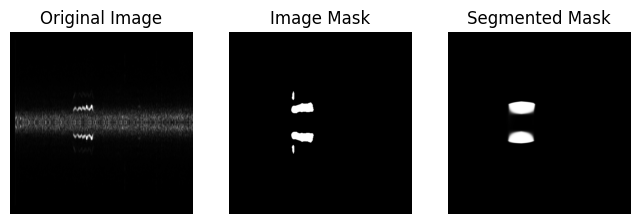

In [28]:
# Example Inference
def segment_image(image_path, model, transform, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)

    return output

# Example Usage
image_path = '/content/drive/MyDrive/new_dataset/new_dataset/test/images/XC58568.png'
segmented_output = segment_image(image_path, model, transform, device)
segmented_mask = torch.sigmoid(segmented_output).cpu().squeeze().numpy()

image = Image.open(image_path).convert("RGB")
image = image.resize((512, 512))

image_mask = Image.open('/content/drive/MyDrive/new_dataset/new_dataset/test/masks/XC58568.png').convert("RGB")
image_mask = image_mask.resize((512, 512))

fig, axs = plt.subplots(1, 3, figsize=(8, 6))

# Display the original image in the first subplot
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(image_mask)
axs[1].set_title('Image Mask')
axs[1].axis('off')

# Display the segmented mask in the second subplot
axs[2].imshow(segmented_mask, cmap='gray')
axs[2].set_title('Segmented Mask')
axs[2].axis('off')

# Show the plot
plt.show()

In [24]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

def calculate_metrics(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred) > threshold
    target = target > threshold

    # Flatten the predictions and targets
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    # Calculate IoU
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    iou_mean = iou.mean().item()

    # Calculate F1 score
    f1 = f1_score(target_flat.cpu().numpy(), pred_flat.cpu().numpy(), average='binary')

    # Calculate Dice score
    intersection_sum = (pred_flat * target_flat).sum().item()
    dice = (2. * intersection_sum) / (pred_flat.sum().item() + target_flat.sum().item() + 1e-6)

    return iou_mean, f1, dice

def evaluate_model(deeplab_model, test_loader, threshold=0.5):
    deeplab_model.eval()  # Set the model to evaluation mode
    all_ious = []
    all_f1s = []
    all_dices = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = deeplab_model(images)

            # Calculate metrics
            iou, f1, dice = calculate_metrics(outputs, labels, threshold)

            all_ious.append(iou)
            all_f1s.append(f1)
            all_dices.append(dice)

    # Compute the mean of each metric
    mean_iou = sum(all_ious) / len(all_ious)
    mean_f1 = sum(all_f1s) / len(all_f1s)
    mean_dice = sum(all_dices) / len(all_dices)

    return mean_iou, mean_f1, mean_dice

# Example usage
mean_iou, mean_f1, mean_dice = evaluate_model(model, test_dataloader)
print(f"Mean IoU: {mean_iou}")
print(f"Mean F1 Score: {mean_f1}")
print(f"Mean Dice Score: {mean_dice}")


Mean IoU: 0.6858799426179183
Mean F1 Score: 0.6550192822629933
Mean Dice Score: 0.6550192822605719


In [25]:
mean_iou, mean_f1, mean_dice = evaluate_model(model, val_dataloader)
print(f"Mean Validation IoU: {mean_iou}")
print(f"Mean Validation F1 Score: {mean_f1}")
print(f"Mean Validation Dice Score: {mean_dice}")

Mean Validation IoU: 0.696297779083252
Mean Validation F1 Score: 0.6553541351289006
Mean Validation Dice Score: 0.6553541351264375


# ResearchGate paper link

https://www.researchgate.net/publication/382943342_Denoising_BirdSounds_using_Image_Segmentation